Desenvolvimento de uma Estratégia Evolutiva e Algoritmo Genético para a determinação do ponto de mínimo global das seguinte função: Schwefel

A forma mais comum (Schwefel 2.26): f(x) = 418.9829⋅d - ∑ xi sin(raiz(|xi|)

- Domínio típico: 𝑥𝑖 ∈ [−500,500]
- Mínimo global: 𝑓(𝑥)=0 em xi = 420.9687 (aprox. para todos i)
- Características: Altamente multimodal, muitos mínimos locais, separável em termos de soma mas enganosa devido aos muitos vales; difícil para busca pura por gradiente.


In [ ]:
import numpy as np
from dataclasses import dataclass, asdict
from typing import List, Tuple, Literal, Callable, Dict


In [ ]:
# 1. Função Schwefel (d = 30 por padrão no experimento)

def schwefel(x: np.ndarray) -> float:
    x = np.asarray(x)
    d = x.size
    return 418.9829 * d - np.sum(x * np.sin(np.sqrt(np.abs(x))))

def schwefel_batch(pop: np.ndarray) -> np.ndarray:
    d = pop.shape[1]
    return 418.9829 * d - np.sum(pop * np.sin(np.sqrt(np.abs(pop))), axis=1)


In [ ]:
# 2. Utilidades

def clamp(pop: np.ndarray, lower=-500.0, upper=500.0):
    np.clip(pop, lower, upper, out=pop)

def initialize(pop_size: int, dim: int, lower=-500.0, upper=500.0) -> np.ndarray:
    return np.random.uniform(lower, upper, size=(pop_size, dim))


In [ ]:
# 3. Configurações GA e EE

@dataclass
class GAConfig:
    dim: int = 30
    pop_size: int = 150
    max_evals: int = 100_000
    p_crossover: float = 0.9
    p_mut_gene: float = None  # se None => 1/dim
    sigma_mut: float = 50.0
    elitism: int = 2
    tournament_k: int = 3
    seed: int = 1234
    lower: float = -500.0
    upper: float = 500.0

    def finalize(self):
        if self.p_mut_gene is None:
            self.p_mut_gene = 1 / self.dim

@dataclass
class ESConfig:
    dim: int = 30
    mu: int = 30            # tamanho dos pais
    lamb: int = 200         # número de descendentes
    max_evals: int = 100_000
    sigma_init: float = 50.0
    tau: float = None       # parâmetros de adaptação (1/√(2√d))
    tau_prime: float = None # (1/√(2d))
    plus_strategy: bool = False  # False => (μ, λ); True => (μ + λ)
    seed: int = 4321
    lower: float = -500.0
    upper: float = 500.0
    self_adapt: bool = True

    def finalize(self):
        if self.tau is None:
            self.tau = 1.0 / np.sqrt(2.0 * np.sqrt(self.dim))
        if self.tau_prime is None:
            self.tau_prime = 1.0 / np.sqrt(2.0 * self.dim)


In [ ]:
# 4. Operadores GA

def tournament_selection(pop, fitness, k):
    idxs = np.random.randint(0, pop.shape[0], size=k)
    return idxs[np.argmin(fitness[idxs])]  # minimização

def crossover_one_point(p1, p2):
    d = p1.size
    point = np.random.randint(1, d)
    c1 = np.empty_like(p1)
    c2 = np.empty_like(p1)
    c1[:point] = p1[:point]
    c1[point:] = p2[point:]
    c2[:point] = p2[:point]
    c2[point:] = p1[point:]
    return c1, c2

def mutate_gaussian(ind, p_mut_gene, sigma, lower, upper):
    mask = np.random.rand(ind.size) < p_mut_gene
    if mask.any():
        ind[mask] += np.random.normal(0.0, sigma, size=mask.sum())
        np.clip(ind, lower, upper, out=ind)


In [ ]:
# 5. Loop GA

def run_ga(cfg: GAConfig, verbose: bool = False):
    cfg.finalize()
    np.random.seed(cfg.seed)

    pop = initialize(cfg.pop_size, cfg.dim, cfg.lower, cfg.upper)
    fitness = schwefel_batch(pop)
    evals = cfg.pop_size

    best_idx = np.argmin(fitness)
    best_fit = fitness[best_idx]
    best_sol = pop[best_idx].copy()

    history: List[Tuple[int, float]] = [(evals, best_fit)]

    while evals < cfg.max_evals:
        # Ordena para elitismo
        order = np.argsort(fitness)
        pop = pop[order]
        fitness = fitness[order]
        elite = pop[:cfg.elitism].copy()
        elite_fit = fitness[:cfg.elitism].copy()

        new_pop = []
        while len(new_pop) < cfg.pop_size - cfg.elitism:
            p1 = pop[tournament_selection(pop, fitness, cfg.tournament_k)]
            p2 = pop[tournament_selection(pop, fitness, cfg.tournament_k)]
            if np.random.rand() < cfg.p_crossover:
                c1, c2 = crossover_one_point(p1, p2)
            else:
                c1, c2 = p1.copy(), p2.copy()
            mutate_gaussian(c1, cfg.p_mut_gene, cfg.sigma_mut, cfg.lower, cfg.upper)
            mutate_gaussian(c2, cfg.p_mut_gene, cfg.sigma_mut, cfg.lower, cfg.upper)
            new_pop.append(c1)
            if len(new_pop) < cfg.pop_size - cfg.elitism:
                new_pop.append(c2)

        new_pop = np.vstack(new_pop)
        pop = np.vstack([elite, new_pop])
        fitness = schwefel_batch(pop)
        evals += pop.shape[0]

        gen_best_idx = np.argmin(fitness)
        gen_best_fit = fitness[gen_best_idx]
        if gen_best_fit < best_fit:
            best_fit = gen_best_fit
            best_sol = pop[gen_best_idx].copy()

        history.append((evals, best_fit))
        if verbose and len(history) % 10 == 0:
            print(f"[GA] evals={evals:7d} best={best_fit:.6f}")

    return {
        "algorithm": "GA",
        "config": asdict(cfg),
        "best_solution": best_sol,
        "best_fitness": best_fit,
        "evaluations": evals,
        "history": history
    }


In [ ]:
# 6. Estratégia Evolutiva (μ, λ) ou (μ + λ) com auto‑adaptação de σ

def run_es(cfg: ESConfig, verbose: bool = False):
    cfg.finalize()
    np.random.seed(cfg.seed)

    # População de pais (μ)
    parents = initialize(cfg.mu, cfg.dim, cfg.lower, cfg.upper)
    # Estratégia: cada indivíduo tem sigma (escala global ou por gene)
    # Aqui: sigma por gene (vetor) para auto-adaptação
    if cfg.self_adapt:
        sigmas = np.full((cfg.mu, cfg.dim), cfg.sigma_init)
    else:
        sigmas = np.full((cfg.mu, cfg.dim), cfg.sigma_init)

    parent_fit = schwefel_batch(parents)
    evals = cfg.mu

    best_idx = np.argmin(parent_fit)
    best_fit = parent_fit[best_idx]
    best_sol = parents[best_idx].copy()

    history: List[Tuple[int, float]] = [(evals, best_fit)]

    while evals < cfg.max_evals:
        # Geração de descendentes
        offspring = np.empty((cfg.lamb, cfg.dim))
        offspring_sigmas = np.empty_like(offspring) if cfg.self_adapt else np.empty((cfg.lamb, cfg.dim))
        for i in range(cfg.lamb):
            # Seleciona um pai (pode usar seleção uniforme ou recombinação)
            idx = np.random.randint(0, cfg.mu)
            x = parents[idx]
            s = sigmas[idx]

            if cfg.self_adapt:
                # Atualiza sigma (log-normal)
                global_noise = np.random.normal(0, 1)
                local_noise = np.random.normal(0, 1, size=cfg.dim)
                new_s = s * np.exp(cfg.tau_prime * global_noise + cfg.tau * local_noise)
                # Evita sigma muito pequeno
                new_s = np.maximum(new_s, 1e-8)
            else:
                new_s = s

            child = x + np.random.normal(0, new_s)
            np.clip(child, cfg.lower, cfg.upper, out=child)

            offspring[i] = child
            offspring_sigmas[i] = new_s

        offspring_fit = schwefel_batch(offspring)
        evals += cfg.lamb

        # Seleção
        if cfg.plus_strategy:
            # (μ + λ)
            total = np.vstack([parents, offspring])
            total_sigmas = np.vstack([sigmas, offspring_sigmas])
            total_fit = np.concatenate([parent_fit, offspring_fit])
            order = np.argsort(total_fit)
            parents = total[order[:cfg.mu]]
            sigmas = total_sigmas[order[:cfg.mu]]
            parent_fit = total_fit[order[:cfg.mu]]
        else:
            # (μ, λ)
            order = np.argsort(offspring_fit)
            parents = offspring[order[:cfg.mu]]
            sigmas = offspring_sigmas[order[:cfg.mu]]
            parent_fit = offspring_fit[order[:cfg.mu]]

        # Atualiza melhor global
        gen_best_idx = np.argmin(parent_fit)
        gen_best_fit = parent_fit[gen_best_idx]
        if gen_best_fit < best_fit:
            best_fit = gen_best_fit
            best_sol = parents[gen_best_idx].copy()

        history.append((evals, best_fit))
        if verbose and len(history) % 10 == 0:
            label = "(μ+λ)" if cfg.plus_strategy else "(μ,λ)"
            print(f"[ES {label}] evals={evals:7d} best={best_fit:.6f}")

    return {
        "algorithm": "ES_plus" if cfg.plus_strategy else "ES_comma",
        "config": asdict(cfg),
        "best_solution": best_sol,
        "best_fitness": best_fit,
        "evaluations": evals,
        "history": history
    }

In [ ]:
# 7. Multi-run para comparar GA vs ES

def multi_run(method: Callable, runs: int, base_seed: int, config_factory: Callable[[int], object], verbose_each=False):
    results = []
    best_values = []
    for i in range(runs):
        seed = base_seed + i
        cfg = config_factory(seed)
        res = method(cfg, verbose=False if not verbose_each else True)
        results.append(res)
        best_values.append(res["best_fitness"])
        print(f"{res['algorithm']} run {i+1:02d} seed={seed} best={res['best_fitness']:.6f}")
    best_values = np.array(best_values)
    summary = {
        "algorithm": results[0]["algorithm"],
        "runs": runs,
        "min": best_values.min(),
        "max": best_values.max(),
        "mean": best_values.mean(),
        "std": best_values.std(ddof=1)
    }
    return results, summary


In [ ]:
# 8. Comparação final

def compare_summaries(summaries: List[Dict]):
    print("\n===== COMPARAÇÃO FINAL (Schwefel, d=30) =====")
    for s in summaries:
        print(f"{s['algorithm']:10s} | runs={s['runs']:2d} | "
              f"min={s['min']:.6f} | mean={s['mean']:.6f} | "
              f"max={s['max']:.6f} | std={s['std']:.6f}")
    # Melhor média
    best_alg = min(summaries, key=lambda x: x["mean"])
    print(f"\nMelhor média de fitness: {best_alg['algorithm']} (mean={best_alg['mean']:.6f})")
    # Observações simples
    print("\nObservações:")
    print("- Schwefel possui muitos ótimos locais; manutenção de diversidade é crítica.")
    print("- GA: diversidade via crossover + mutação; ajuste de sigma_mut influencia exploração.")
    print("- ES: auto-adaptação de σ permite ajuste fino local após encontrar regiões promissoras.")
    print("- (μ + λ) tende a convergir mais rápido, mas pode reduzir diversidade comparado a (μ, λ).")


In [ ]:
# 10. Execução principal

if __name__ == "__main__":
    # Parâmetros comuns
    DIM = 30
    MAX_EVALS = 100_000
    RUNS = 30          # Ajuste para 30 se quiser relatório mais robusto
    print("Iniciando experimentos Schwefel (d=30)...\n")

    # ---------- GA multi-run ----------
    def ga_factory(seed):
        return GAConfig(
            dim=DIM,
            pop_size=150,
            max_evals=MAX_EVALS,
            p_crossover=0.9,
            p_mut_gene=None,    # 1/d
            sigma_mut=50.0,
            elitism=2,
            tournament_k=3,
            seed=seed,
            lower=-500.0,
            upper=500.0
        )

    ga_results, ga_summary = multi_run(
        method=run_ga,
        runs=RUNS,
        base_seed=1234,
        config_factory=ga_factory
    )

    # ---------- ES (μ, λ) multi-run ----------
    def es_comma_factory(seed):
        return ESConfig(
            dim=DIM,
            mu=30,
            lamb=200,
            max_evals=MAX_EVALS,
            sigma_init=50.0,
            plus_strategy=False,  # (μ, λ)
            seed=seed,
            lower=-500.0,
            upper=500.0,
            self_adapt=True
        )

    es_comma_results, es_comma_summary = multi_run(
        method=run_es,
        runs=RUNS,
        base_seed=4321,
        config_factory=es_comma_factory
    )

    # ---------- ES (μ + λ) multi-run (opcional) ----------
    def es_plus_factory(seed):
        return ESConfig(
            dim=DIM,
            mu=30,
            lamb=200,
            max_evals=MAX_EVALS,
            sigma_init=50.0,
            plus_strategy=True,   # (μ + λ)
            seed=seed,
            lower=-500.0,
            upper=500.0,
            self_adapt=True
        )

    es_plus_results, es_plus_summary = multi_run(
        method=run_es,
        runs=RUNS,
        base_seed=5321,
        config_factory=es_plus_factory
    )
    compare_summaries([ga_summary, es_comma_summary, es_plus_summary])

Iniciando experimentos Schwefel (d=30)...

GA run 01 seed=1234 best=1382.200377
GA run 02 seed=1235 best=2171.678396
GA run 03 seed=1236 best=949.237449
GA run 04 seed=1237 best=1046.618665
GA run 05 seed=1238 best=1718.133516
GA run 06 seed=1239 best=1145.465575
GA run 07 seed=1240 best=928.196906
GA run 08 seed=1241 best=1500.649972
GA run 09 seed=1242 best=1184.755309
GA run 10 seed=1243 best=2075.943232
GA run 11 seed=1244 best=1164.995556
GA run 12 seed=1245 best=1125.882575
GA run 13 seed=1246 best=1977.458742
GA run 14 seed=1247 best=1046.540639
GA run 15 seed=1248 best=1956.002067
GA run 16 seed=1249 best=1264.802681
GA run 17 seed=1250 best=1521.504728
GA run 18 seed=1251 best=1936.265118
GA run 19 seed=1252 best=1403.097587
GA run 20 seed=1253 best=1719.161649
GA run 21 seed=1254 best=1481.362956
GA run 22 seed=1255 best=1739.082171
GA run 23 seed=1256 best=1619.053473
GA run 24 seed=1257 best=1165.331529
GA run 25 seed=1258 best=1915.289374
GA run 26 seed=1259 best=1176.5242

Iniciando experimentos Schwefel (d=30)...

GA run 01 seed=1234 best=1382.200377
GA run 02 seed=1235 best=2171.678396
GA run 03 seed=1236 best=949.237449
GA run 04 seed=1237 best=1046.618665
GA run 05 seed=1238 best=1718.133516
GA run 06 seed=1239 best=1145.465575
GA run 07 seed=1240 best=928.196906
GA run 08 seed=1241 best=1500.649972
GA run 09 seed=1242 best=1184.755309
GA run 10 seed=1243 best=2075.943232
GA run 11 seed=1244 best=1164.995556
GA run 12 seed=1245 best=1125.882575
GA run 13 seed=1246 best=1977.458742
GA run 14 seed=1247 best=1046.540639
GA run 15 seed=1248 best=1956.002067
GA run 16 seed=1249 best=1264.802681
GA run 17 seed=1250 best=1521.504728
GA run 18 seed=1251 best=1936.265118
GA run 19 seed=1252 best=1403.097587
GA run 20 seed=1253 best=1719.161649
GA run 21 seed=1254 best=1481.362956
GA run 22 seed=1255 best=1739.082171
GA run 23 seed=1256 best=1619.053473
GA run 24 seed=1257 best=1165.331529
GA run 25 seed=1258 best=1915.289374
GA run 26 seed=1259 best=1176.5242

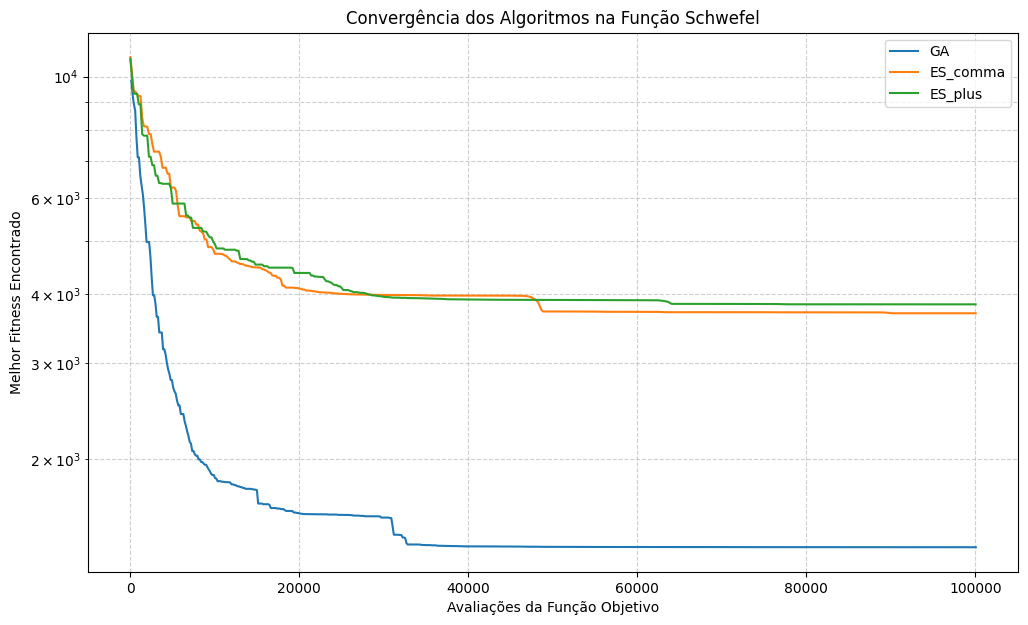

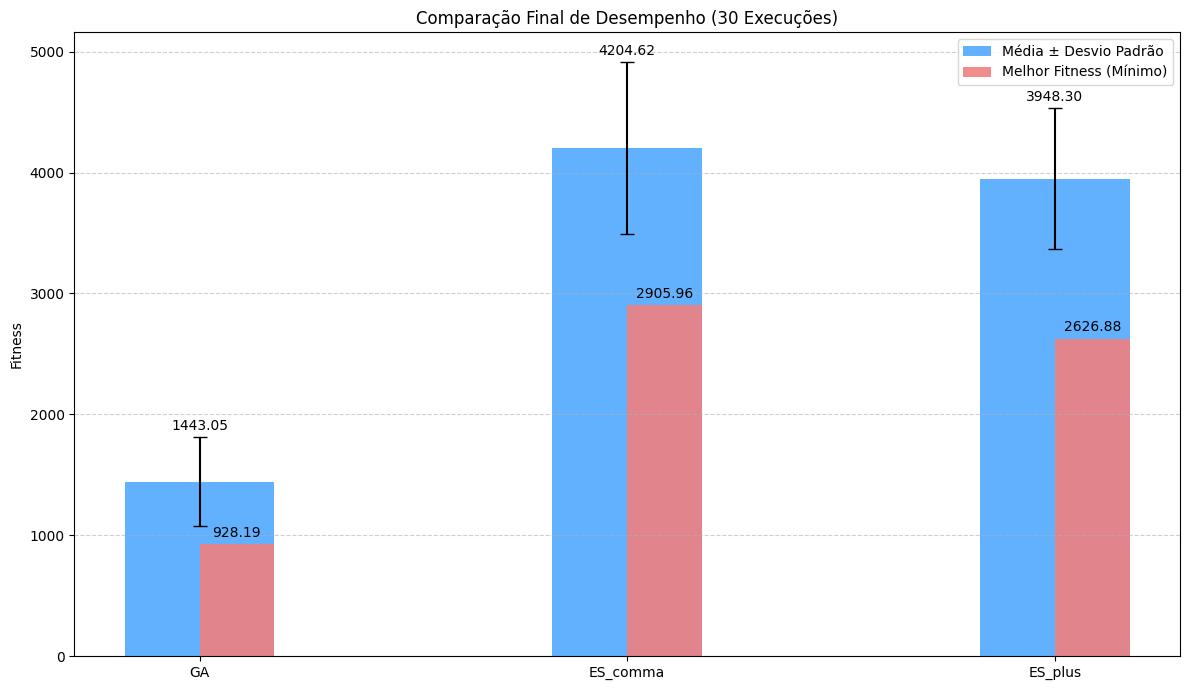


--- Gráficos salvos como 'comparacao_convergencia.png' e 'comparacao_final_barras.png' ---


In [ ]:
# ==============================================================================
# SEÇÃO 9: GERAÇÃO DE GRÁFICOS E VISUALIZAÇÃO
# ==============================================================================
import matplotlib.pyplot as plt
import pandas as pd

def plot_convergence_history(results_list: List[Dict], title: str = "Convergência dos Algoritmos na Função Schwefel"):
    """
    Plota o histórico de convergência para uma lista de resultados de algoritmos.

    Args:
        results_list: Uma lista de dicionários, onde cada dicionário é o resultado
                      de uma execução (ex: ga_results[0], es_comma_results[0]).
        title: O título do gráfico.
    """
    plt.figure(figsize=(12, 7))
    for res in results_list:
        # Extrai o histórico de uma única execução (a primeira de cada tipo)
        history = res[0]['history']
        df = pd.DataFrame(history, columns=['evaluations', 'best_fitness'])
        plt.plot(df['evaluations'], df['best_fitness'], label=res[0]['algorithm'])

    plt.title(title)
    plt.xlabel("Avaliações da Função Objetivo")
    plt.ylabel("Melhor Fitness Encontrado")
    plt.yscale('log')  # Escala logarítmica é útil para ver melhor a convergência
    plt.grid(True, which="both", linestyle='--', alpha=0.6)
    plt.legend()
    plt.savefig('comparacao_convergencia.png')
    plt.show()

def plot_final_comparison(summaries: List[Dict]):
    """
    Plota um gráfico de barras comparando as métricas finais (min, mean, max) dos algoritmos.

    Args:
        summaries: A lista de dicionários de resumo (ga_summary, es_comma_summary, etc.).
    """
    labels = [s['algorithm'] for s in summaries]
    means = [s['mean'] for s in summaries]
    stds = [s['std'] for s in summaries]
    mins = [s['min'] for s in summaries]

    x = np.arange(len(labels))
    width = 0.35

    fig, ax = plt.subplots(figsize=(12, 7))
    rects1 = ax.bar(x, means, width, yerr=stds, capsize=5, label='Média ± Desvio Padrão', color='dodgerblue', alpha=0.7)
    rects2 = ax.bar(x, mins, width/2, label='Melhor Fitness (Mínimo)', color='lightcoral', alpha=0.9, align='edge')


    ax.set_ylabel('Fitness')
    ax.set_title('Comparação Final de Desempenho (30 Execuções)')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()
    ax.bar_label(rects1, padding=3, fmt='%.2f')
    ax.bar_label(rects2, padding=3, fmt='%.2f')

    plt.grid(True, axis='y', linestyle='--', alpha=0.6)
    fig.tight_layout()
    plt.savefig('comparacao_final_barras.png')
    plt.show()


# ==============================================================================
# SEÇÃO 10: Execução principal com Geração de Gráficos
# ==============================================================================

if __name__ == "__main__":
    # Parâmetros comuns
    DIM = 30
    MAX_EVALS = 100_000
    RUNS = 30
    print("Iniciando experimentos Schwefel (d=30)...\n")

    # ---------- GA multi-run ----------
    def ga_factory(seed):
        return GAConfig(dim=DIM, max_evals=MAX_EVALS, seed=seed)

    ga_results, ga_summary = multi_run(
        method=run_ga, runs=RUNS, base_seed=1234, config_factory=ga_factory
    )

    # ---------- ES (μ, λ) multi-run ----------
    def es_comma_factory(seed):
        return ESConfig(dim=DIM, max_evals=MAX_EVALS, plus_strategy=False, seed=seed)

    es_comma_results, es_comma_summary = multi_run(
        method=run_es, runs=RUNS, base_seed=4321, config_factory=es_comma_factory
    )

    # ---------- ES (μ + λ) multi-run ----------
    def es_plus_factory(seed):
        return ESConfig(dim=DIM, max_evals=MAX_EVALS, plus_strategy=True, seed=seed)

    es_plus_results, es_plus_summary = multi_run(
        method=run_es, runs=RUNS, base_seed=5321, config_factory=es_plus_factory
    )

    # Imprime o resumo final na console
    summaries = [ga_summary, es_comma_summary, es_plus_summary]
    compare_summaries(summaries)

    # Gera e exibe os gráficos
    print("\n--- Gerando Gráficos ---")

    # Gráfico 1: Histórico de convergência da primeira execução de cada algoritmo
    plot_convergence_history([ga_results, es_comma_results, es_plus_results])

    # Gráfico 2: Comparação final com média, desvio padrão e mínimo
    plot_final_comparison(summaries)

    print("\n--- Gráficos salvos como 'comparacao_convergencia.png' e 'comparacao_final_barras.png' ---")